In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 08/11/2021

    Code description :
    __________________
    Check that observations y are the same between the different observations models.
    Then compare the reconstructions to check they work the same.
    The object of interest is in 2D.

    Note: we see, as expected from the theory, that the ROP in 2D is faster than autocorrelation.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...

In [43]:
"Parameters"
N = 128 # image sidelength
K = 8 # sparsity
Q = 10 # Number of cores
# M=20*K # Number of observations y
M=500

"Create the sample space"
pos_x = np.random.randint(0, high=N, size=K)
pos_y = np.random.randint(0, high=N, size=K)
f = np.zeros((N,N))
"Define the sparse object"
for i in range(K):
    f[pos_x[i], pos_y[i]] = (1)**i

"Fermat spiral"
diam_endo = np.sqrt(2)*(N/2) # Must be N for coherency between image resolution and cores distances
pos_sources = LE_cores (diam_endo, Q, sources_shape = 'fermat')
pos_inds = np.round((pos_sources+diam_endo/2)*N/diam_endo).astype(int) # convert sources positions to indices in R^(NxN) space.

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om_x = np.subtract.outer(pos_inds[0,:], pos_inds[0,:]).astype(int)
Om_y = np.subtract.outer(pos_inds[1,:], pos_inds[1,:]).astype(int)

a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core
a_ij_outer = np.zeros((Q,Q,M), dtype=complex)
for m in range(M):
    a_ij_outer[:,:,m] = np.outer(a_ij[m], a_ij[m].conj())

In [103]:
"ROP model"
A_op = lambda Xin: np.real(A(S_Om(T(Xin), Om_x, Om_y), a_ij, diagless=False))
# At_op = lambda Xin: np.real(T_star(S_Om_star(A_star(Xin, a_ij_outer, diagless=False), Om_x, Om_y, f.shape) ))
At_op = lambda Xin: np.real(T_star(S_Om_star(A_star2(Xin, a_ij, diagless=False), Om_x, Om_y, f.shape) ))
nu_rop1 = eval_nu(np.random.randn(N,N), A_op, At_op, nb_iter=50)*1.01
adjoint_test(A=A_op,A_star=At_op,A_shape=[[N,N],[M]])
y1 = A_op(f)
adjoint1 = At_op(y1)

"Circulant matrix completion model"
B = np.zeros((N,N,M), dtype=complex)
B[pos_inds[0], pos_inds[1],:] = a_ij.T
B2 = corr_circ2(B.conj())
thepos0, thepos1 = np.where(np.abs(B2[:,:,0])>1e-10)
B3 = B2[thepos0, thepos1,:]

# g = lambda Xin: np.real(np.tensordot(T(Xin), B2)) /np.sqrt(M)
g = lambda Xin: np.real(T(Xin)[thepos0, thepos1]@B3) /np.sqrt(M) # As each frame of B2 is the autocorrelation of an Q-sparse image, it is Q^2-sparse. Thus we can reduce the complexity 
# to MQ^2 instead of MN^2
gt = lambda Xin: np.real(T_star( np.conj(B2@Xin) )) /np.sqrt(M)
nu_rop2 = eval_nu(np.random.randn(N,N), g, gt, nb_iter=50)*1.01
adjoint_test(A=g,A_star=gt,A_shape=[[N,N],[M]])
y2 = g(f)
adjoint2 = gt(y2)

y_norm = np.linalg.norm(y1)**2
assert np.sum(np.abs(nu_rop1-nu_rop2))<1e-8*y_norm, "The nu are different..."
assert np.sum(np.abs(y1-y2))<1e-8*y_norm, "The observations are different..."
assert np.sum(np.abs(adjoint1-adjoint2))<1e-8*y_norm, "The adjoints are different..."

A and At are adjoint!
A and At are adjoint!


In [4]:
solver = solvers.forward_backward(step=1/(2*nu_rop1) )

maxit=300
SNR_target = 60
epsilon = np.linalg.norm(f)*10**(-SNR_target/20)
bigit = 10

Solution found after 300 iterations:
    objective function f(sol) = 5.355119e+00
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.456080e-02
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.581199e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.222759e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.308406e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.371894e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.467753e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.516908e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.554775e-03
    stopping criterion

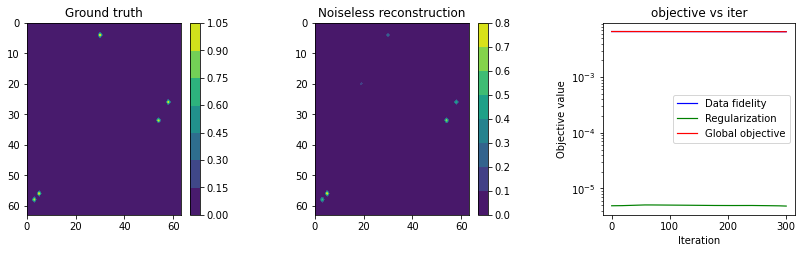

SNR: 5.90 dB


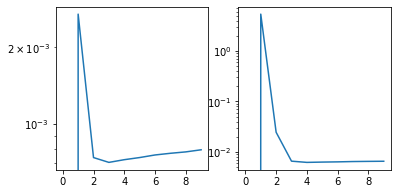

In [5]:
f2 = functions.norm_l2(y=y1, A=A_op, At=At_op, nu=nu_rop1, tight=True)

lamb1 = 1
f_hat1 = np.zeros(f.shape)
lambs1 = np.zeros(bigit)
objectives1 = np.zeros(bigit)
i=1
while (i<bigit): # and snr(f, f_hat)<40):
    x0 = f_hat1
    f1 = functions.norm_l1(lambda_=lamb1)
    ret1 = solvers.solve([f1, f2], x0, solver, rtol=1e-8, maxit=maxit) #, verbosity='NONE')
    f_hat1 = ret1['sol']
    lamb1 *= epsilon/np.linalg.norm(A_op(ret1['sol'])-y2)
    lambs1[i] = lamb1
    objectives1[i] = np.sum(np.array(ret1['objective'])[-1,:])
    i+=1

show_rec2D(f, ret1['sol'], objective=ret1['objective'], show_Fourier=False)

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(lambs1, linewidth=1.5)
plt.gca().set_yscale('log')
plt.subplot(122)
plt.plot(objectives1, linewidth=1.5)
plt.gca().set_yscale('log')
plt.show()

Solve $\hat{\boldsymbol{X}} = \text{argmin}_{\boldsymbol{X}}~ \tau \left\lVert \mathcal{A}(\boldsymbol{S}_{\Omega} \boldsymbol{T} \boldsymbol{X})-\boldsymbol{y} \right\rVert_2^2 + \left\lVert \boldsymbol{X} \right\rVert_1$

Solution found after 500 iterations:
    objective function f(sol) = 7.966170e+00
    stopping criterion: MAXIT


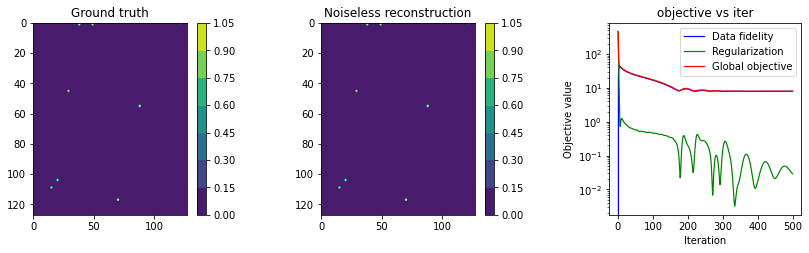

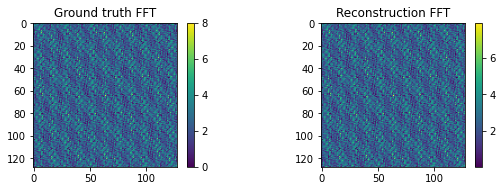

SNR: 41.90 dB


In [20]:
"Version wo/ bigit"
tau=1e2 # weight between sparsity and data fidelity 
f1 = functions.norm_l1()
nu_rop = eval_nu(f, A_op, At_op, nb_iter=50)*1.01
f2 = functions.norm_l2(y=y1, A=A_op, At=At_op, lambda_=tau, nu=nu_rop) 
solver = solvers.forward_backward(step=1/(2*tau*nu_rop) )

x0 = np.zeros(f.shape)
Xhat_data = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=500)
Xhat = Xhat_data['sol']
show_rec2D(f, Xhat, objective=Xhat_data['objective'], show_Fourier=True)

Solution found after 300 iterations:
    objective function f(sol) = 5.355119e+00
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 2.456080e-02
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.581199e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.223274e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.308275e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.371206e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.467359e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.517299e-03
    stopping criterion: MAXIT
Solution found after 300 iterations:
    objective function f(sol) = 6.555446e-03
    stopping criterion

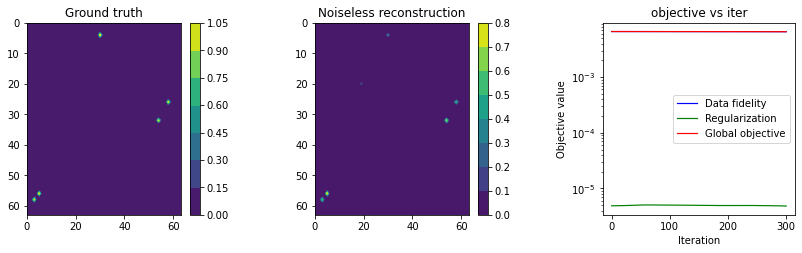

SNR: 5.90 dB


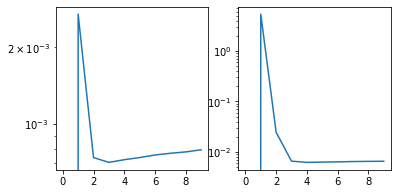

In [6]:
f2 = functions.norm_l2(y=y2, A=g, At=gt, nu=nu_rop2, tight=True)

f_hat2 = np.zeros(f.shape)
lambs2 = np.zeros(bigit)
objectives2 = np.zeros(bigit)
lamb2 = 1
i=1
while (i<bigit and snr(f, f_hat2)<40):
    x0 = f_hat2
    f1 = functions.norm_l1(lambda_=lamb2)
    ret2 = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=maxit) #, verbosity='NONE')
    f_hat2 = ret2['sol']
    lamb2 *= epsilon/np.linalg.norm(g(ret2['sol'])-y2)
    lambs2[i] = lamb2
    objectives2[i] = np.sum(np.array(ret2['objective'])[-1,:])
    i+=1

show_rec2D(f, ret2['sol'], objective=ret2['objective'], show_Fourier=False )

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(lambs2, linewidth=1.5)
plt.gca().set_yscale('log')
plt.subplot(122)
plt.plot(objectives2, linewidth=1.5)
plt.gca().set_yscale('log')
plt.show()